
# Deep Learning with CNNs (David Nallapu - 001530978)

Abstract : Deep Learning with CNNs is an effective to classsify images of dogs based on their breeds. This study aims to classify dog breeds. Hyperparameter tuning will be done to understand the performance of the hyperparameters. This study looks at the impact of changing the actiovation function, cost function, no. of epochs, gradient estimation, network architecture, network initialization. We will see loss, accuracy and other metrics on TensorBoard to understand performance . We will also see that certain paramerter tuning causes a dramatic difference. The findings from this study indicate that it is important to do hyper parameter tuning for Deep Learning with CNNs.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import torchvision
from torch.utils.tensorboard import SummaryWriter
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Data directory
data_dir = os.path.abspath("dog_breeds_cnn.ipynb")[:-len("dog_breeds_cnn.ipynb")]

#Applying Transformation
train_transforms = transforms.Compose([
                                    transforms.Resize(32),
                                      transforms.CenterCrop(32),
                                transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize(32),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + 'data/train',  
                                    transform=train_transforms)                                       
test_data = datasets.ImageFolder(data_dir + 'data/test', 
                                    transform=test_transforms)

In [3]:
#Creating loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([32, 3, 32, 32])

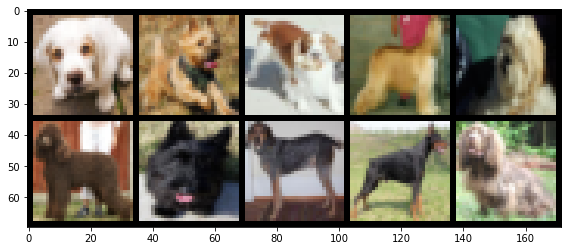

In [4]:
#Viewing the images
for images,labels in train_loader:
    break
im = make_grid(images[0:10], nrow= 5) 
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))
images.shape

In [5]:
class Network(nn.Module):
    def __init__ (self, af, weights_init, hd_layers):
        super().__init__()
        self.af=af
        self.weights_init=weights_init
        self.hd_layers = hd_layers
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 5,kernel_size = 5) 
        
        if weights_init=='xavier':
            torch.nn.init.xavier_uniform(self.conv1.weight)
        self.conv2 = nn.Conv2d(in_channels = 5,out_channels = 20,kernel_size = 3)         
        
        if self.hd_layers == 3:
            self.fc1 = nn.Linear(720,360)
            self.fc2 = nn.Linear(360,240)
            self.fc3 = nn.Linear(240,120)
        else:
            self.fc1 = nn.Linear(720,480)
            self.fc2 = nn.Linear(480,360)
            self.fc3 = nn.Linear(360,240)
            self.fc4 = nn.Linear(240,120)

    def forward(self,x):
        if self.af=='relu':
            x = F.relu(self.conv1(x))
            x = F.max_pool2d(x,2,2)
            x = F.relu(self.conv2(x))  
            x = F.max_pool2d(x,2,2)
            #Flattening
            x = x.view(-1,torch.prod(torch.tensor(x.shape[1:])).item())        

            x = F.relu(self.fc1(x))        
            x = F.relu(self.fc2(x))  
            x = F.log_softmax(self.fc3(x),dim = 1)    
            return(x)
        else:
            x = F.leaky_relu(self.conv1(x))
            x = F.max_pool2d(x,2,2)
            x = F.leaky_relu(self.conv2(x))  
            x = F.max_pool2d(x,2,2)

            x = x.view(-1,torch.prod(torch.tensor(x.shape[1:])).item())        

            x = F.leaky_relu(self.fc1(x))        
            x = F.leaky_relu(self.fc2(x))  
            x = F.log_softmax(self.fc3(x),dim = 1)    
            return(x)
            

In [6]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [7]:
from itertools import product

parameters = dict(
    af = ['relu','leaky_relu'],
    cf = ['cross_entropy','nll_loss'],
    epochs = [5,10],
    ge = ['adam'],
    hd_layers = [3,4],
    weights = ['default','xavier']
)

param_values = [v for v in parameters.values()]

for af,cf,epochs,ge,hd_layers,weights in product(*param_values):
    network = Network(af , weights, hd_layers)
    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)
    comment = f' af={af} cf={cf} epochs={epochs} ge ={ge} weights = {weights}'
    tb = SummaryWriter(comment=comment)
    tb.add_image('images',grid)
    tb.add_graph(network,images)
    lr = 0.001
    
    if(ge=='adam'):
        optimizer = torch.optim.Adam(network.parameters(), lr = lr)
    else:
        optimizer = torch.optim.SGD(network.parameters(), lr = lr)
    print("Activation:",af,"Cost:",cf,"Epochs:",epochs,"Gradient:",ge,"Hidden layers:",hd_layers, "Weights:",weights)    
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_accuracy = 0
        b_num = 0#no. of batches
        # Run the training batches
        for batch in train_loader:
            b_num+=1
            images,labels = batch  

            # Apply the model
            preds = network(images)
            
            if cf =='nll_loss':
                loss = F.cross_entropy(preds,labels)#Calculating loss
            else:
                loss = F.nll_loss(preds,labels)

            # Updating parameters
            optimizer.zero_grad()
            loss.backward()#Calculating gradients
            optimizer.step()#Updating weights
                
            
            total_loss+=loss.item()
            total_correct+=get_num_correct(preds,labels)
            total_accuracy+=get_num_correct(preds,labels)/len(preds)

        tb.add_scalar("Loss", total_loss, epoch)
        tb.add_scalar("Correct", total_correct, epoch)
        tb.add_scalar("Accuracy", (total_accuracy/b_num)*100)

        tb.add_histogram("conv1.bias", network.conv1.bias, epoch)
        tb.add_histogram("conv1.weight", network.conv1.weight, epoch)
        tb.add_histogram("conv2.bias", network.conv2.bias, epoch)
        tb.add_histogram("conv2.weight", network.conv2.weight, epoch)

        print("epoch:", epoch, "total_correct:", total_correct, "loss:",total_loss,"accuracy:",(total_accuracy/b_num)*100)
    print()
tb.close()

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a c

Activation: relu Cost: cross_entropy Epochs: 5 Gradient: adam Hidden layers: 3 Weights: default
epoch: 0 total_correct: 281 loss: 1700.880520582199 accuracy: 2.3416666666666663
epoch: 1 total_correct: 484 loss: 1590.1779763698578 accuracy: 4.033333333333333
epoch: 2 total_correct: 665 loss: 1541.1436507701874 accuracy: 5.541666666666667
epoch: 3 total_correct: 828 loss: 1500.9958865642548 accuracy: 6.9
epoch: 4 total_correct: 1030 loss: 1462.6166727542877 accuracy: 8.583333333333334



/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # Remove the CWD from sys.path while we load stuff.


Activation: relu Cost: cross_entropy Epochs: 5 Gradient: adam Hidden layers: 3 Weights: xavier
epoch: 0 total_correct: 201 loss: 1749.936752796173 accuracy: 1.675
epoch: 1 total_correct: 497 loss: 1604.2701215744019 accuracy: 4.141666666666667
epoch: 2 total_correct: 648 loss: 1549.4653978347778 accuracy: 5.4
epoch: 3 total_correct: 778 loss: 1516.0440168380737 accuracy: 6.483333333333334
epoch: 4 total_correct: 905 loss: 1483.9119200706482 accuracy: 7.541666666666667

Activation: relu Cost: cross_entropy Epochs: 5 Gradient: adam Hidden layers: 4 Weights: default
epoch: 0 total_correct: 223 loss: 1749.1753568649292 accuracy: 1.8583333333333334
epoch: 1 total_correct: 463 loss: 1614.7817516326904 accuracy: 3.858333333333333
epoch: 2 total_correct: 664 loss: 1559.1211097240448 accuracy: 5.533333333333333
epoch: 3 total_correct: 833 loss: 1516.9019265174866 accuracy: 6.941666666666666
epoch: 4 total_correct: 967 loss: 1473.5056931972504 accuracy: 8.058333333333334

Activation: relu Cost: 

epoch: 4 total_correct: 1140 loss: 1448.0342116355896 accuracy: 9.5
epoch: 5 total_correct: 1310 loss: 1404.8779599666595 accuracy: 10.916666666666666
epoch: 6 total_correct: 1547 loss: 1364.397623538971 accuracy: 12.891666666666667
epoch: 7 total_correct: 1765 loss: 1313.4519114494324 accuracy: 14.708333333333334
epoch: 8 total_correct: 2066 loss: 1264.2681744098663 accuracy: 17.216666666666665
epoch: 9 total_correct: 2380 loss: 1212.820963859558 accuracy: 19.833333333333332

Activation: relu Cost: nll_loss Epochs: 10 Gradient: adam Hidden layers: 4 Weights: default
epoch: 0 total_correct: 186 loss: 1779.6175866127014 accuracy: 1.55
epoch: 1 total_correct: 455 loss: 1637.8030121326447 accuracy: 3.791666666666667
epoch: 2 total_correct: 590 loss: 1573.609116077423 accuracy: 4.916666666666666
epoch: 3 total_correct: 729 loss: 1536.6825749874115 accuracy: 6.075
epoch: 4 total_correct: 858 loss: 1502.5124869346619 accuracy: 7.1499999999999995
epoch: 5 total_correct: 1051 loss: 1470.496384

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a c

Activation: leaky_relu Cost: cross_entropy Epochs: 5 Gradient: adam Hidden layers: 3 Weights: default
epoch: 0 total_correct: 184 loss: 1754.2047038078308 accuracy: 1.5333333333333332
epoch: 1 total_correct: 440 loss: 1622.80233335495 accuracy: 3.6666666666666665
epoch: 2 total_correct: 703 loss: 1554.3299021720886 accuracy: 5.858333333333333
epoch: 3 total_correct: 888 loss: 1497.8601598739624 accuracy: 7.3999999999999995
epoch: 4 total_correct: 1136 loss: 1446.4109289646149 accuracy: 9.466666666666667

Activation: leaky_relu Cost: cross_entropy Epochs: 5 Gradient: adam Hidden layers: 3 Weights: xavier
epoch: 0 total_correct: 203 loss: 1759.3517198562622 accuracy: 1.6916666666666667
epoch: 1 total_correct: 510 loss: 1598.301304101944 accuracy: 4.25
epoch: 2 total_correct: 750 loss: 1532.1344811916351 accuracy: 6.25
epoch: 3 total_correct: 948 loss: 1477.8821187019348 accuracy: 7.9
epoch: 4 total_correct: 1230 loss: 1420.6004612445831 accuracy: 10.25

Activation: leaky_relu Cost: cross

epoch: 9 total_correct: 4096 loss: 949.2196755409241 accuracy: 34.13333333333333

Activation: leaky_relu Cost: nll_loss Epochs: 10 Gradient: adam Hidden layers: 3 Weights: xavier
epoch: 0 total_correct: 270 loss: 1712.9866662025452 accuracy: 2.25
epoch: 1 total_correct: 621 loss: 1568.3188207149506 accuracy: 5.175
epoch: 2 total_correct: 826 loss: 1513.3872368335724 accuracy: 6.883333333333333
epoch: 3 total_correct: 1068 loss: 1455.9245324134827 accuracy: 8.9
epoch: 4 total_correct: 1341 loss: 1391.674700975418 accuracy: 11.175
epoch: 5 total_correct: 1733 loss: 1323.501268863678 accuracy: 14.441666666666666
epoch: 6 total_correct: 2175 loss: 1236.381840467453 accuracy: 18.125
epoch: 7 total_correct: 2770 loss: 1139.655314207077 accuracy: 23.083333333333332
epoch: 8 total_correct: 3501 loss: 1018.28617811203 accuracy: 29.175
epoch: 9 total_correct: 4453 loss: 884.264331817627 accuracy: 37.108333333333334

Activation: leaky_relu Cost: nll_loss Epochs: 10 Gradient: adam Hidden layers: 4

In [10]:
from itertools import product

parameters = dict(
    af = ['leaky-relu'],
    cf = ['nll_loss'],
    epochs = [30],
    ge = ['adam'],
    hd_layers = [4],
    weights = ['xavier']
)

param_values = [v for v in parameters.values()]

for af,cf,epochs,ge,hd_layers,weights in product(*param_values):
    network = Network(af , weights, hd_layers)
    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)
    comment = f' af={af} cf={cf} epochs={epochs} ge ={ge} weights = {weights}'
    lr = 0.001
    
    if(ge=='adam'):
        optimizer = torch.optim.Adam(network.parameters(), lr = lr)
    else:
        optimizer = torch.optim.SGD(network.parameters(), lr = lr)
    print("Activation:",af,"Cost:",cf,"Epochs:",epochs,"Gradient:",ge,"Hidden layers:",hd_layers, "Weights:",weights)    
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_accuracy = 0
        # Run the training batches
        b_num = 0#no. of batches
        for batch in train_loader:
            b_num+=1
            images,labels = batch  
            # Apply the model
            preds = network(images)
            if cf =='nll_loss':
                loss = F.cross_entropy(preds,labels)#Calculating loss
            else:
                loss = F.nll_loss(preds,labels)

            # Updating parameters
            optimizer.zero_grad()
            loss.backward()#Calculating gradients
            optimizer.step()#Updating weights
            
            total_loss+=loss.item()
            total_correct+=get_num_correct(preds,labels)
            total_accuracy+=get_num_correct(preds,labels)/len(preds)
        
        print("epoch:", epoch, "total_correct:", total_correct, "loss:",total_loss,"accuracy:",(total_accuracy/b_num)*100)
    print()
tb.close()

/Users/davidnallapu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # Remove the CWD from sys.path while we load stuff.


Activation: leaky-relu Cost: nll_loss Epochs: 30 Gradient: adam Hidden layers: 4 Weights: xavier
epoch: 0 total_correct: 222 loss: 1755.9703397750854 accuracy: 1.8499999999999999
epoch: 1 total_correct: 505 loss: 1612.5154023170471 accuracy: 4.208333333333333
epoch: 2 total_correct: 765 loss: 1544.8693878650665 accuracy: 6.375
epoch: 3 total_correct: 953 loss: 1486.0808329582214 accuracy: 7.941666666666666
epoch: 4 total_correct: 1257 loss: 1418.246745109558 accuracy: 10.475
epoch: 5 total_correct: 1640 loss: 1343.3072452545166 accuracy: 13.666666666666666
epoch: 6 total_correct: 2184 loss: 1248.7209160327911 accuracy: 18.2
epoch: 7 total_correct: 2805 loss: 1137.847812652588 accuracy: 23.375
epoch: 8 total_correct: 3718 loss: 997.3711667060852 accuracy: 30.983333333333334
epoch: 9 total_correct: 4857 loss: 835.8898260593414 accuracy: 40.475
epoch: 10 total_correct: 6345 loss: 649.8859177827835 accuracy: 52.87500000000001
epoch: 11 total_correct: 7834 loss: 473.4875698685646 accuracy: 

### Changing the activation function

Leaky-relu performs better than relu from our study

### Changing the cost function
NLL-Loss alogirthm does better than cross-entropy from our study

### Changing the number of epochs

Increasing from 5 to 10 has increased the accuracy. There is no plateuing at this point. 
We can see that after 30 epochs it doesnt cross 98.04% accuracy with chosen hyperparameters

### Changing the gradient estimation

Adam seems to always do better than stochasatic gradient here. Stochastic Gradient's loss seems to be constant hence I'm not running it in my simulation.

### Changing the network architecture

Increasing the no. of hidden layers from 3 to 4 increases the accuracy to a large extent for this problem.

### Changing the network initialization

Xavier leads to an increase in accuracy compared to the default torch init in the start of most simulations. The deault weights init does catch up eventually and performs better.

## Conclusion
We can conclude that hyperparameters are paramount in CNNs.Leaky-relu performs better than relu from our study. NLL-Loss alogirthm does better than cross-entropy from our study. Increasing from 5 to 10 has increased the accuracy. There is no plateuing at this point. Simulation needs to be run for more epochs on a faster cpu for more information. Adam optimizer seems to always do better than stochasatic gradient here. Stochastic Gradient's loss seems to be constant hence I'm not running it in my simulation.Increasing the no. of hidden layers from 3 to 4 increases the accuracy to a large extent for this problem. Xavier weights initialization leads to an increase in accuracy compared to the default torch init in most simulations. We achieve an accuracy of 96.7% accuracy over 21 epochs with Leaky-Relu, Adam Optimizitation, and NLL Loss with 4 hidden layers.

## References
[1]: Dataset : https://www.kaggle.com/miljan/stanford-dogs-dataset-traintest#

[2]: CNN : https://www.datacamp.com/community/tutorials/cnn-tensorflow-python 

[3]: PyTorch : https://medium.com/@thinkai.org/using-pytorch-for-building-a-convolutional-neural-network-cnn-model-6e47ffb61b88

[4]: Classification : https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

[5]: Classification :https://becominghuman.ai/building-a-convolutional-neural-network-cnn-model-for-image-classification-116f77a7a236

## Licensing

Copyright 2021 David Samuel Nallapu
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.